In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from IPython.display import clear_output
from time import sleep
from pylab import rcParams

%matplotlib inline
%load_ext autoreload
%autoreload 2

rcParams['figure.figsize'] = 10, 20

In [2]:
from env.env_2players_naive_torus import NaiveSandbox

In [3]:
from loss.losses import sum_loss_l1
from model.a2c import *

In [4]:
def probs_to_cells(probs, env, topk=3, player=1):
    probs_top_k, idx_top_k = probs.topk(topk)
    inserted_block = np.zeros(env.shape)
    inserted_block = inserted_block.flatten()
    inserted_block[idx_top_k] = player
    return inserted_block.reshape(env.shape)

In [5]:
def render(perception_field, env_state, render_agent=True):
    clear_output(wait=True)
    if render_agent:
        plt.imshow(perception_field)
        plt.show()
    #print('field after agent inference')
    plt.imshow(env_state['grid'])
    plt.show()

In [6]:
import torch
import torch.optim as optim

In [7]:
from reward.rewards import AliveCellsReward, MultipleAgentsCellsReward
reward_fn = MultipleAgentsCellsReward()

In [8]:
def step_agent(agent, agent_id=1):
    probs = agent.get_action_probs(torch.tensor(sandbox.get_grid()).float().flatten())
    perception_field = probs_to_cells(probs.detach(), sandbox.get_grid(), N_CELLS, player=agent_id)
    sandbox.insert_block(perception_field, 0, 0)
    return perception_field

In [9]:
def play_game(iterations, state, render_env=True):
    for i in range(iterations):
        perception_1 = step_agent(agent_1, 1)
        perception_2 = step_agent(agent_2, 2)
        sandbox.step(steps_after_action)
        
        rewards = reward_fn(sandbox.get_grid())
        
        env_state = {"grid": sandbox.get_grid(), "rewards":  rewards, "done": sandbox.is_done()}
        if render_env:
            render(perception_1, env_state)
        next_state, reward, done = env_state['grid'], env_state['rewards'], env_state['done']
        
        states.append(state.flatten());dones.append(done);
        rewards1.append(reward[0])
        rewards2.append(reward[1])
        actions1.append(perception_1) 
        actions2.append(perception_2)
        
        state = next_state
    print (np.mean(rewards1), np.mean(rewards2))

In [10]:
def reflect_agent(agent, optimizer, states, actions, rewards, dones, list_loss):
    total_loss = agent.reflect(states, actions, rewards, dones)
    optimizer.zero_grad()
    total_loss.backward()
    if np.isnan(total_loss.item()):
        return
    list_loss.append(total_loss.item())
    torch.nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
    optimizer.step()

In [15]:
x0, y0 = 0, 0
iterations = 100
steps_after_action = 5
N_GAMES = 10
N_CELLS = 10
GRID = 10
LR = 0.001

grid_size=(GRID,GRID)
sandbox = NaiveSandbox(grid_size=grid_size)
state = sandbox.get_grid()

In [16]:
agent_1 = ActorCritic(GRID*GRID, GRID*GRID)
agent_2 = ActorCritic(GRID*GRID, GRID*GRID)

optimizer_1 = optim.Adam(agent_1.parameters(), lr=LR)
optimizer_2 = optim.Adam(agent_2.parameters(), lr=LR)

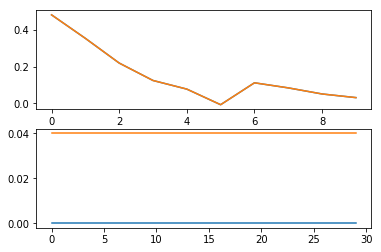

In [17]:
list_loss1, list_loss2 = [], []
for game in range(N_GAMES):
    states, actions1, actions2, rewards1, rewards2, dones = [], [], [], [], [], []
    
    play_game(30, state, render_env=False)

    reflect_agent(agent_1, optimizer_1, states, actions1, rewards1, dones, list_loss1)
    reflect_agent(agent_2, optimizer_2, states, actions2, rewards2, dones, list_loss2)
    
    clear_output(wait=True)
    
    plt.subplot(2, 1, 1)
    plt.plot(list(range(len(list_loss1))), list_loss2)

    #plt.subplot(4, 1, 2)
    plt.plot(list(range(len(list_loss2))), list_loss2)
    
    plt.subplot(2, 1, 2)
    plt.plot(list(range(len(rewards1))), rewards1)

    #plt.subplot(4, 2, 2)
    plt.plot(list(range(len(rewards2))), rewards2)
    
    plt.show()
    

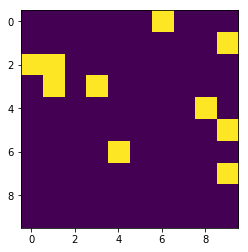

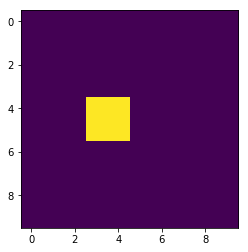

0.0 0.04


In [20]:
state = sandbox.get_grid()
from time import sleep
states, actions, rewards, dones = [], [], [], []
play_game(10, state)

In [19]:
state

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])